# Lab Assignment - 7

### CS22B1093 Rohan G

----------------------

Using device: cuda
Episode 0, Average Reward: 49.00
Episode 50, Average Reward: 11.70
Episode 100, Average Reward: 12.42
Episode 150, Average Reward: 40.22
Episode 200, Average Reward: 27.16
Episode 250, Average Reward: 139.66
Episode 300, Average Reward: 133.84
Episode 350, Average Reward: 175.36
Episode 400, Average Reward: 92.68
Episode 450, Average Reward: 105.16
Episode 500, Average Reward: 189.68
Episode 550, Average Reward: 271.38
Episode 600, Average Reward: 9.32
Episode 650, Average Reward: 9.42
Episode 700, Average Reward: 9.28
Episode 750, Average Reward: 9.56
Episode 800, Average Reward: 9.30
Episode 850, Average Reward: 9.36
Episode 900, Average Reward: 9.32
Episode 950, Average Reward: 9.26


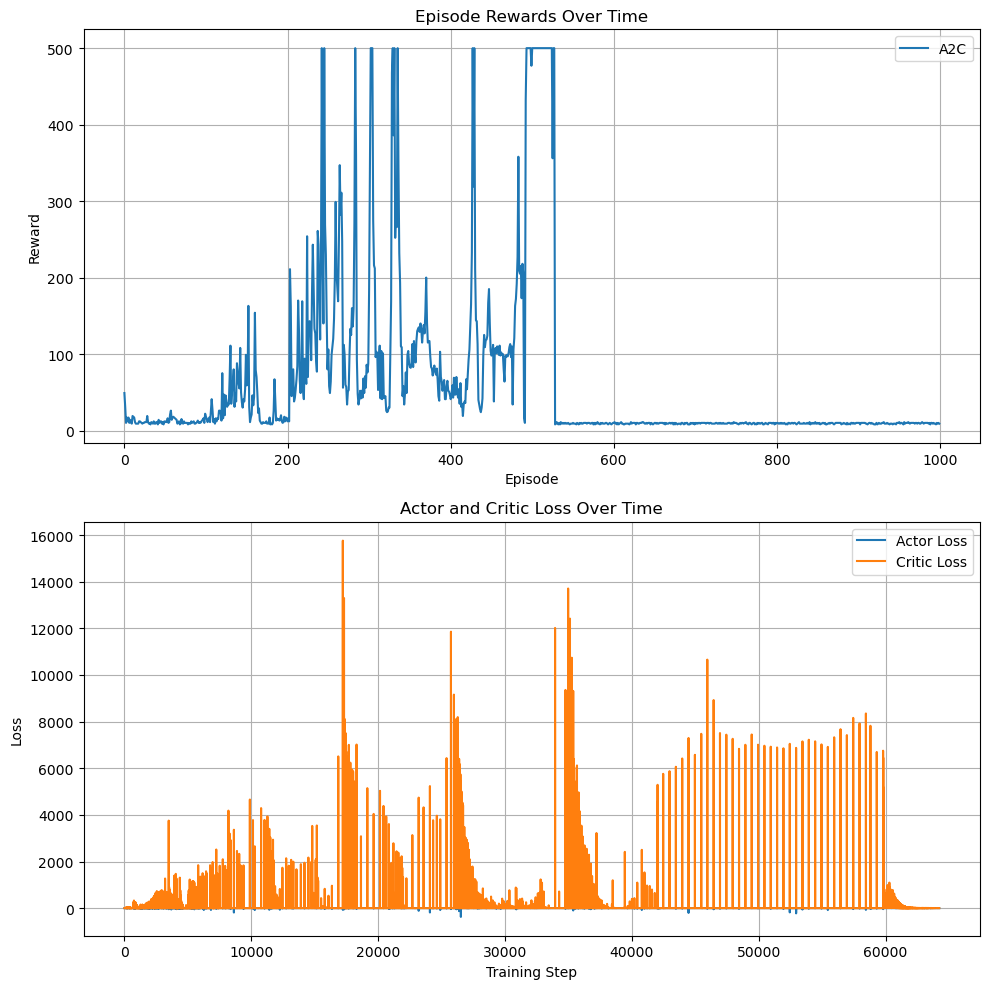

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Actor network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

# Critic network
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

# Select action based on policy
def select_action(actor, state):
    state = torch.tensor(state, dtype=torch.float32, device=device)
    probs = actor(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

# Training loop
def train_a2c(env, actor, critic, num_episodes=1000, gamma=0.99, actor_lr=1e-3, critic_lr=1e-3):
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

    episode_rewards = []
    actor_losses = []
    critic_losses = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = select_action(actor, state)
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            value = critic(state_tensor)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)
            next_value = critic(next_state_tensor)

            # Advantage calculation (TD error)
            td_target = reward + gamma * next_value * (1 - int(done))
            advantage = td_target - value

            # Actor update
            actor_loss = -log_prob * advantage.detach()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            actor_losses.append(actor_loss.item())

            # Critic update
            critic_loss = (value - td_target.detach()).pow(2)
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            critic_losses.append(critic_loss.item())

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)

        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")

    return episode_rewards, actor_losses, critic_losses

# Plot rewards and losses
def plot_rewards_and_losses(rewards, actor_losses, critic_losses, label='A2C'):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot rewards
    axs[0].plot(rewards, label=label)
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Reward")
    axs[0].set_title("Episode Rewards Over Time")
    axs[0].legend()
    axs[0].grid()

    # Plot losses
    axs[1].plot(actor_losses, label="Actor Loss")
    axs[1].plot(critic_losses, label="Critic Loss")
    axs[1].set_xlabel("Training Step")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Actor and Critic Loss Over Time")
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Main
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim).to(device)

rewards, actor_losses, critic_losses = train_a2c(env, actor, critic)
plot_rewards_and_losses(rewards, actor_losses, critic_losses)


Using cuda device


/home/rzeta/.local/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | 24.2     |
| time/              |          |
|    fps             | 924      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


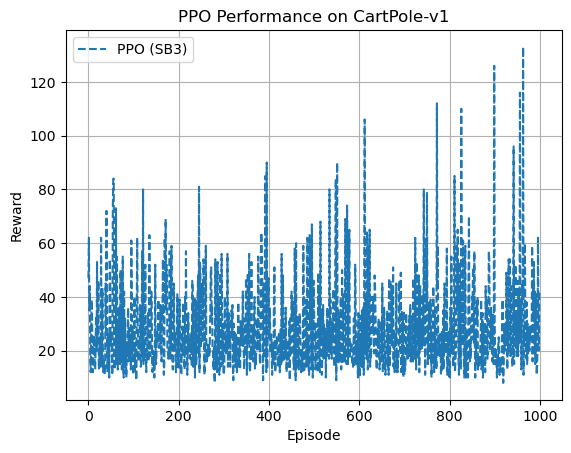

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create vectorized environment for PPO
env_id = "CartPole-v1"
vec_env = make_vec_env(env_id, n_envs=1)

# Create PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)

# Train PPO model
model.learn(total_timesteps=100)

# Evaluate PPO model
def evaluate_agent(model, env_id, episodes=1000):
    rewards = []
    for _ in range(episodes):
        env = gym.make(env_id)
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return rewards

# Run evaluation
ppo_rewards = evaluate_agent(model, env_id)

# Plot rewards
plt.plot(ppo_rewards, label='PPO (SB3)', linestyle='--')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO Performance on CartPole-v1")
plt.legend()
plt.grid()
plt.show()


-------------------------